In [4]:
import pandas as pd

from significance_analysis import conduct_analysis

# Load example dataset
data = pd.read_csv("./example_dataset.csv")

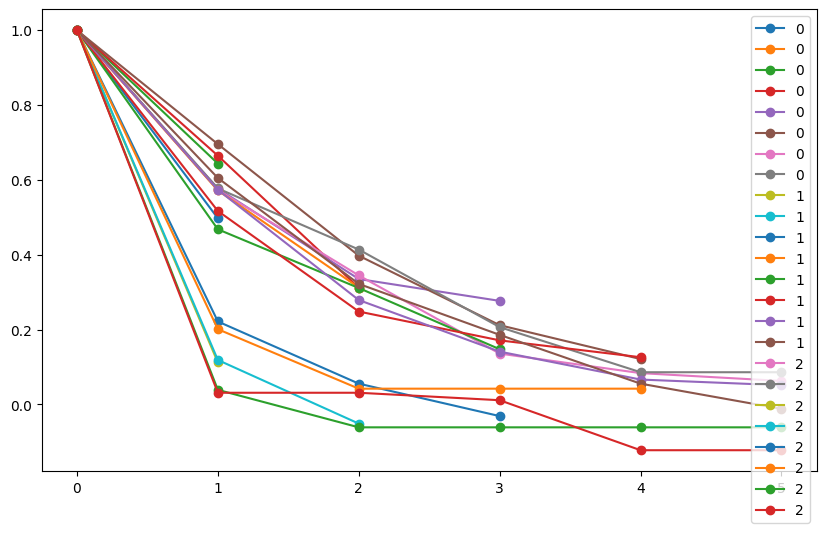

In [147]:
import numpy as np
import matplotlib.pyplot as plt
def algo_simulator(budget:int,quality:float,noise:float,relevant_points:list[int]=[]):
    if not relevant_points:
        relevant_points=np.linspace(0,budget,False)
    best_points=[1]
    points=[0]
    for i in range(1,budget):
        new_point=(np.exp(-quality*i)+np.random.normal(size=1,scale=noise))[0]
        best_points.append(np.min([best_points[-1],new_point]))
        if not i+1 in relevant_points:
            best_points.pop()
        else:
            points.append(i)
    #best_points.pop(0)
    return best_points,points

points=[0,1,2,3,4,5,6]
max_budget=8
number_of_workers=4
runs=[]
quality=[0.5,0.6,2]
color=["red","blue","gray"]
for algo_number in range(len(quality)):
    for current_budget in range(1,max_budget):
        for worker in range(int(np.ceil(number_of_workers/(2*(current_budget))))):
            #print(f"Budget: {current_budget}, Worker: {worker}")
            run=algo_simulator(budget=current_budget,quality=quality[algo_number],relevant_points=points,noise=0.05)
            #print(run)
            if run[0]!=[]:
                runs.append(list(run)+[algo_number])


_, axis = plt.subplots(figsize=(10, 6))
for number,group in enumerate(runs):
    axis.errorbar(
        group[1],
        group[0],
        fmt="o-",
        capsize=3,
        label=group[2],
        ecolor=color[group[2]]
    )
#axis.set_xlabel(bin_id)
#axis.set_ylabel("Estimate")
#axis.set_title(f"Estimates by {system_id} and {bin_id}")
axis.legend()
plt.show()